In [1]:
import pandas as pd
import numpy as np
import tensorboard as tb
import seaborn as sns
import time
from datetime import timedelta
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator as ea
from pathlib import Path

In [2]:
# take every X sample for plot (raw log interval: 20k frames) default: 10
DATA_PLOT_SPARSITY = 10

# rolling average sample window (applied after sparsity) default: 10
DATA_PLOT_SMOOTHNESS = 10

MAX_TRAINING_STEPS = 20000000
# max value of linspace. used to align step values from all seeds and env to be the same. max 
STEP_SPACE_END_VALUE = 20


# in and out dirs
logs_dir = Path("baselines_logs")
variants = ["scobots", "iscobots", "rgb"]
out_dir = Path.cwd() / Path("plots")

# envs to look for in logdir and subdirs and plot
envs = ["Pong", "Boxing", "Tennis", "Bowling", "Skiing", "Freeway", "Kangaroo", "Asterix"]
envs = sorted(envs)

# experiments to exclude from plots:
dont_plot = []

# scalars to look for in tfevent files and plot
SCALAR_TO_PLOT = "rollout/ep_env_rew_mean"
    



In [3]:
def time_str(delta):
    x = str(delta).split(":")
    return f"{x[0]}h {x[1]}m {x[2]}s"
    

# for one env
def parse_env(env, everyx=5, smooth_window=5):
    exp_list = []
    for variant in variants:
        variant_dir = logs_dir / Path(variant)
        for p in variant_dir.rglob("*"):
            if p.is_file():
                if env in str(p.parents[0].name):
                    split_name = p.parents[0].name.split("_")
                    seed = split_name[1][1:]
                    if "rgb" in seed:
                        seed = seed.split("-")[0]
                    exp_name = split_name[0]
                    if p.parents[0].name in dont_plot:
                        continue
                    exp_list.append((seed, p.parents[0]))
    exp_list = set(exp_list) # remove duplicates
    if len(exp_list) == 0:
        return None
    exp_str_list = " ".join([str(n[0]) for n in exp_list])

    # {seed : [(tag, s.step, s.value, seed),...]}
    data_dict = {}
    seed_progress = [[],[],[]]
    netto_log_entries_list = []
    for seed, log_dir in exp_list:
        log_entries = 0
        max_step  = 0
        max_wt = 0
        pdir = log_dir.parents[0].name
        if pdir == "scobots":
            scobi_mode = 0
        elif pdir == "iscobots":
            scobi_mode = 1
        else:
            scobi_mode = 2
        for file in log_dir.iterdir():
            if 'tfevents' in file.name:
                acc = ea.EventAccumulator(str(file))
                acc.Reload()
                scalar_list = acc.Tags()['scalars']  
                key = seed + "_" + str(scobi_mode)
                for tag in scalar_list:
                    write_tag = ""
                    if scobi_mode == 2 and tag == "rollout/ep_rew_mean": #rgb seeds log fix
                        write_tag = "rollout/ep_env_rew_mean"
                    if tag == SCALAR_TO_PLOT:
                        write_tag = tag
                    if write_tag:
                        for s in acc.Scalars(tag):
                            if not key in data_dict.keys():
                                data_dict[key] = []
                            data_dict[key].append((write_tag, s.step, s.value, seed, scobi_mode, s.wall_time))
                            log_entries += 1
                            max_step = s.step if max_step < s.step else max_step
                            max_wt = s.wall_time if max_wt < s.wall_time else max_wt

        seed_progress[scobi_mode].append((seed, log_entries, max_wt))
        # make comparable: twice as many rgb logs, but one step represents 4 frames
        log_entries = int(log_entries / 4) if scobi_mode != 2 else int(log_entries / 2) 
        netto_log_entries_list.append(log_entries)
    seed_progress[0] = sorted(seed_progress[0], key=lambda x: x[0])
    seed_progress[1] = sorted(seed_progress[1], key=lambda x: x[0])
    seed_progress[2] = sorted(seed_progress[2], key=lambda x: x[0])
    now = time.time()
    
    scobi_seeds_str = "\tscobi\n" + "\n".join([f"\t\t{x}\t{y}\t\t{time_str(timedelta(seconds=int(now-z)))} ago" for x, y, z in seed_progress[0]])
    iscobi_seeds_str = "\tiscobi\n" + "\n".join([f"\t\t{x}\t{y}\t\t{time_str(timedelta(seconds=int(now-z)))} ago" for x, y, z in seed_progress[1]])
    rgb_seeds_str = "\trgb\n" + "\n".join([f"\t\t{x}\t{y}\t\t{time_str(timedelta(seconds=int(now-z)))} ago" for x, y, z in seed_progress[2]])
    
    print(f"{env}")
    print(scobi_seeds_str)
    print(iscobi_seeds_str)
    print(rgb_seeds_str)

    
    first_n_log_entries = min(netto_log_entries_list)
    print(first_n_log_entries)
    def preprocess_seed_log(df):
        scalar_df = df[df["tag"] == SCALAR_TO_PLOT].copy()
        scalar_df = scalar_df.sort_values(by=["step"], ascending=True) #sort first
        scalar_df = scalar_df.drop_duplicates(subset=['step'], keep="last")
        if scalar_df["scobi_mode"][0] != 2:
            scalar_df = scalar_df.iloc[::4, :] #take every 4 sample to align with rgb logging
        scalar_df = scalar_df.head(first_n_log_entries)
        scalar_df = scalar_df.iloc[::everyx, :]
        scalar_df["value"] = scalar_df.value.rolling(smooth_window, min_periods=1).mean()
        step_space = np.linspace(0, STEP_SPACE_END_VALUE, len(scalar_df.index))
        scalar_df["step"] = step_space
        return scalar_df
    
    seed_results = []    
    for k, v in data_dict.items():
        seed_df = pd.DataFrame(v, columns=["tag", "step", "value", "seed", "scobi_mode", "wall_time"])
        seed_results.append(preprocess_seed_log(seed_df))

    # merge and return seed dataframes
    return pd.concat(seed_results, ignore_index=True)

In [4]:
data_to_plot = {}

# goes over every specified env and
# creates dict: {env : {scalar1 : df, scalar2 : df, ...}, env2 : {scalar1 : df, scalar2 :df, ...}, ...}
print("env\tmode\tseed\tlog_entries\tlast log update")
for e in envs:
    env_result_df = parse_env(e, DATA_PLOT_SPARSITY, DATA_PLOT_SMOOTHNESS)
    if len(env_result_df.index) > 0:
        data_to_plot[e] = env_result_df
np.save('curve_data_to_plot.npy', data_to_plot) 

env	mode	seed	log_entries	last log update
Asterix
	scobi
		0	9765		78 days, 20h 28m 42s ago
		16	9765		78 days, 20h 45m 25s ago
		32	9765		78 days, 20h 35m 17s ago
	iscobi
		0	9765		75 days, 2h 47m 10s ago
		16	9765		75 days, 2h 48m 25s ago
		32	9765		75 days, 2h 45m 14s ago
	rgb
		0	4882		2 days, 0h 27m 11s ago
		16	4882		2 days, 0h 23m 54s ago
		32	4882		2 days, 0h 23m 49s ago
2441
Bowling
	scobi
		0	9750		81 days, 16h 09m 42s ago
		16	9750		81 days, 16h 07m 16s ago
		32	9750		81 days, 16h 28m 31s ago
	iscobi
		0	9750		81 days, 16h 47m 33s ago
		16	9750		81 days, 17h 16m 12s ago
		32	9750		81 days, 17h 27m 47s ago
	rgb
		0	4868		2 days, 0h 06m 06s ago
		16	4867		1 day, 23h 46m 56s ago
		32	4867		1 day, 23h 50m 15s ago
2433
Boxing
	scobi
		0	9753		81 days, 17h 15m 06s ago
		16	9753		81 days, 17h 30m 04s ago
		32	9753		81 days, 17h 21m 23s ago
	iscobi
		0	9753		81 days, 17h 37m 21s ago
		16	9753		81 days, 17h 36m 20s ago
		32	9753		81 days, 17h 26m 45s ago
	rgb
		0	4870		2 days, 0h 22m

In [5]:
data_to_plot = np.load('curve_data_to_plot.npy',allow_pickle='TRUE').item()
#print(data_to_plot)
#tdf = data_to_plot["Skiing"]['rollout/ep_env_rew_mean']
#tdf = tdf[tdf.scobi_mode == 2]
#print(len(tdf.index))
tdf = data_to_plot["Pong"]
tdf = tdf[tdf.scobi_mode == 0]
print(len(tdf.index))
#tdf = data_to_plot["Boxing"]['rollout/ep_env_rew_mean']
#tdf = tdf[tdf.scobi_mode == 2]
#print(len(tdf.index))
tdf = data_to_plot["Skiing"]
tdf = tdf[tdf.scobi_mode == 2]
print(len(tdf.index))
#tdf.sort_values(by=["step"], ascending=True).head(50)

732
729


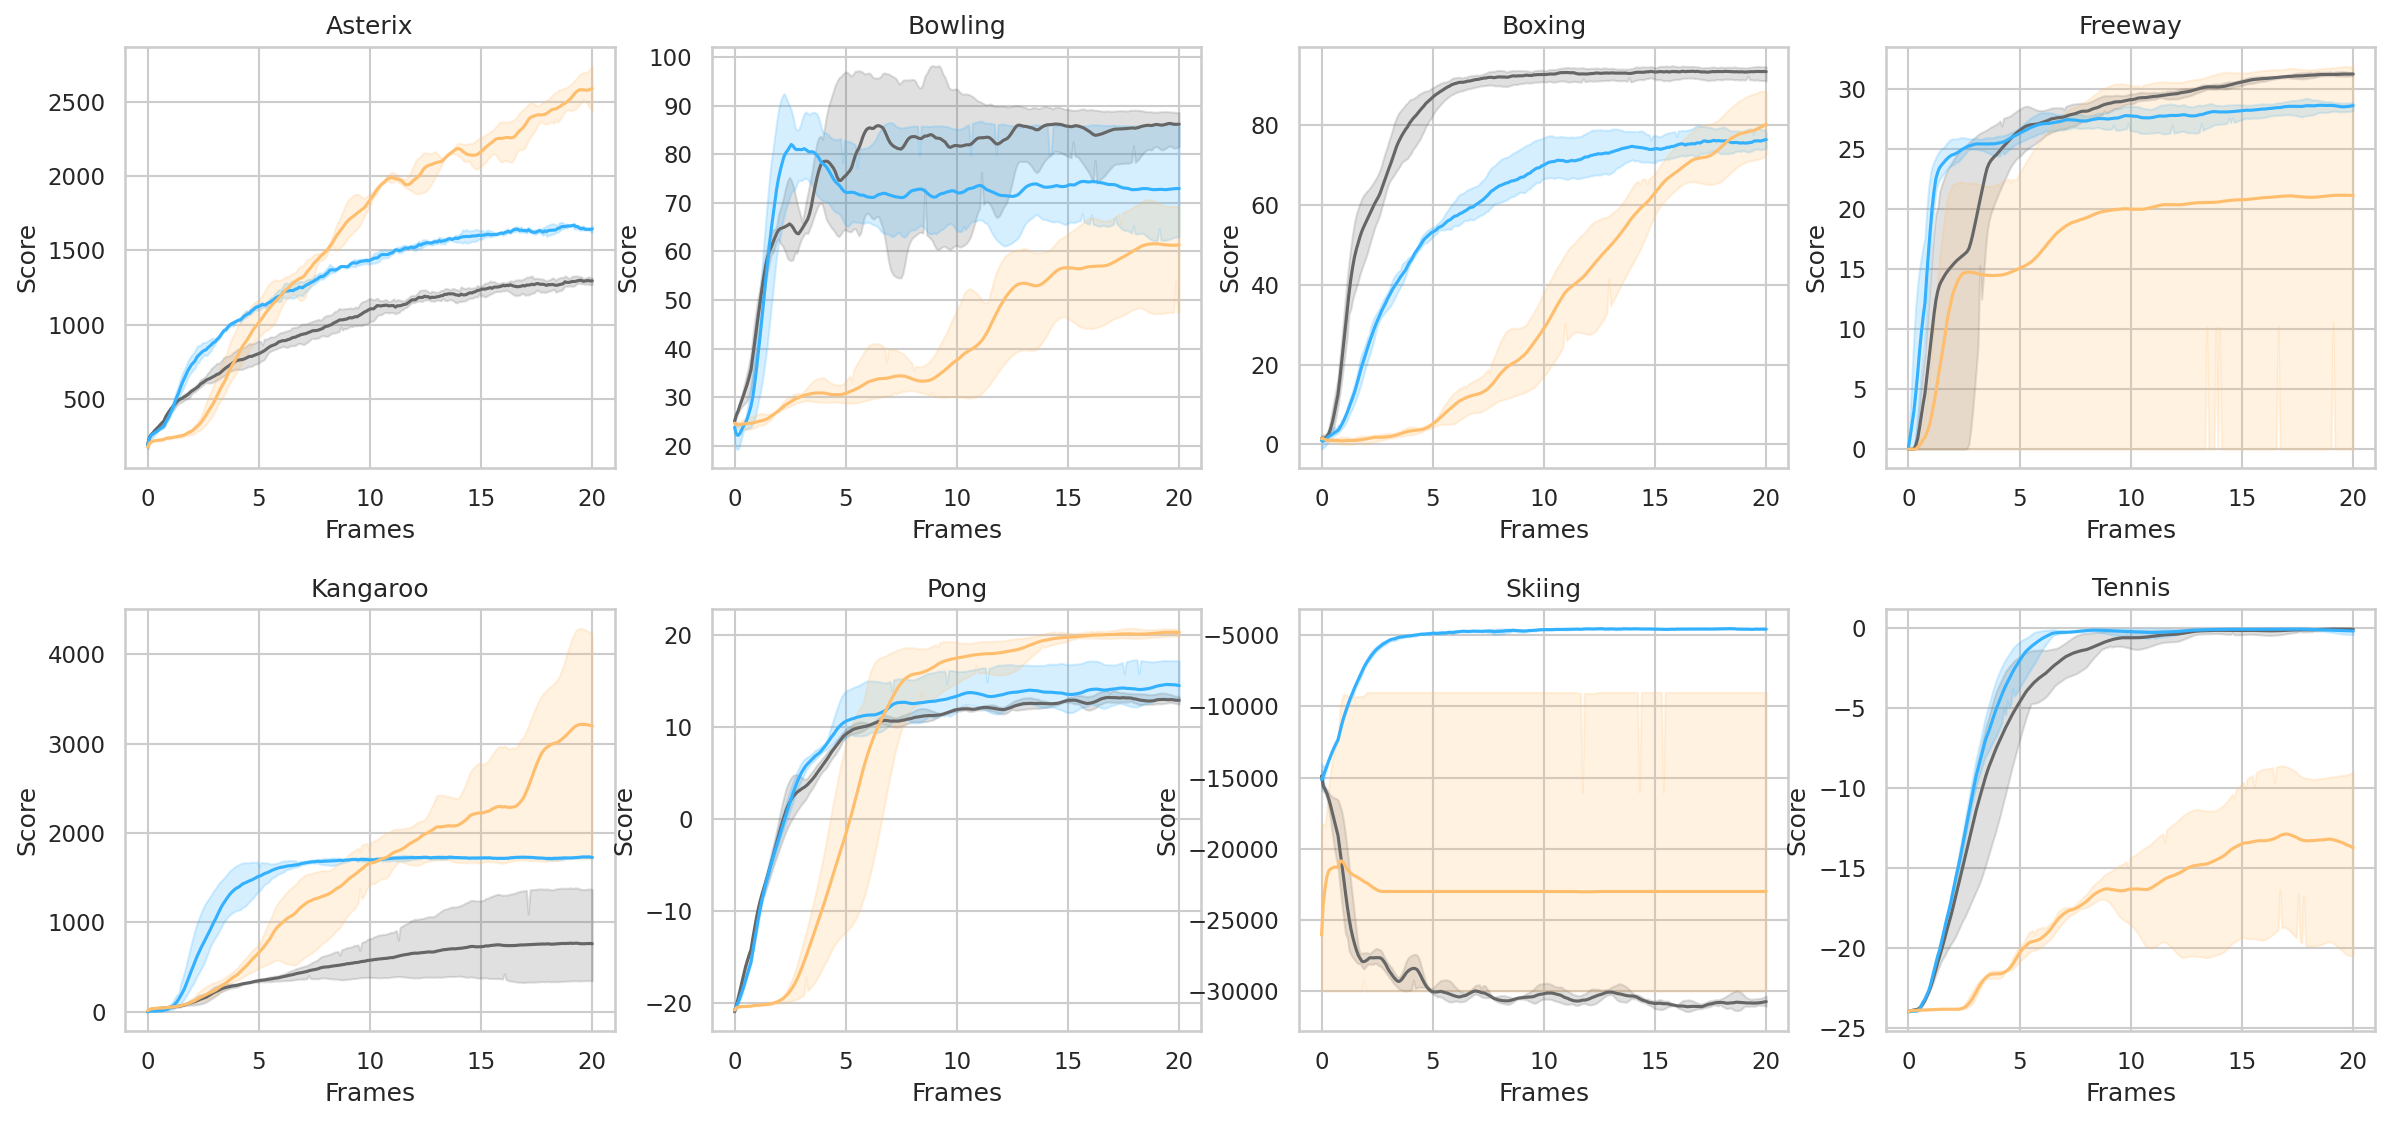

In [19]:
#sns.set_theme()
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("whitegrid")
fig_width = 15
no_envs = len(data_to_plot)
width_per_plot = fig_width / 4
fig_size = (fig_width, 2*width_per_plot)
fig = plt.figure(figsize=fig_size, dpi=150)
subfigs = fig.subfigures(2, 1)
row = -1
axes = None

colors = ["#666666", "#33B1FF", "#FFBE6D"]
pal = sns.color_palette(colors)

# env interator
for i, (k, v) in enumerate(data_to_plot.items()):
    col = i % 4
    if col == 0:
        row += 1
        axes = subfigs[row].subplots(1, 4)

    #subfigs[row].suptitle(str(k), fontsize=22, y=1)
    #print(v["rollout/ep_env_rew_mean"].sort_values(by="step").tail(20))
    order = sorted(v["scobi_mode"].unique())
    s_plt = sns.lineplot(data=v,
                         x="step", 
                         y="value", 
                         hue="scobi_mode", 
                         palette=pal, 
                         hue_order=order, 
                         ax=axes[col])
    axes[col].get_legend().remove()
    s_plt.set(
        xlabel = "Frames",
        ylabel = "Score",
        xticks = [0, 5, 10, 15, 20],
        xticklabels = [0, 5, 10, 15, 20],
        #ylabel = s_descriptions["ylabel"],
        title  = k)


plt.subplots_adjust(top = 0.9, bottom=0.15, left=0, right=1)
plt.show(fig)
fig.savefig(out_dir / "results.png", bbox_inches='tight')
fig.savefig(out_dir / "results.pdf", bbox_inches='tight')
fig.savefig(out_dir / "results.svg", bbox_inches='tight')